Runs two basic convolutional networks on the pilot dataset.

### Things to do next
- Figure out how to do regression (see below).
- ~~Figure out how to do multitask learning (i.e. try to predict the different reps and different genes).~~
- ~~Run on the scale up dataset.~~
- Read up on the "Interpreting a DragoNN model using filter visualization" and "Interpreting data with a DragoNN model" in the Dragonn tutorial.

### Installing Dragonn
- Clone from https://github.com/kundajelab/dragonn
- ```python setup.py```
    - I needed to ```brew install geos```

In [1]:
from dragonn import models
from dragonn.plot import add_letters_to_axis

from sklearn.model_selection import train_test_split

from collections import OrderedDict
from pprint import pprint
from warnings import warn

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Read in the data.
- Samples are sequences that will be one hot encoded
- Try and predict the normalized values. **I couldn't figure out how to do regression with Dragonn, so I just rounded the values to 0 or 1 based on the median.**

In [2]:
key_to_seq = OrderedDict()

with open("../data/Scaleup_counts_sequences/ScaleUpDesign1.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        
        # TODO: Figure out if this is an OK thing to do. 'N' basically means the 
        # sequencing software couldn't figure out what the base was...?
        if "N" in seq:
            warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
            seq = seq.replace("N", "A")
        
        assert key not in key_to_seq
        key_to_seq[key] = seq
        
with open("../data/Scaleup_counts_sequences/ScaleUpDesign2.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        
        if "N" in seq:
            warn("Replacing 'N' bases in seq with 'A' in seq {}.".format(seq))
            seq = seq.replace("N", "A")
        
        assert key not in key_to_seq
        key_to_seq[key] = seq
        
pprint(key_to_seq.items()[:5])

print "{} total sequences of length {}".format(len(key_to_seq), len(key_to_seq.values()[0]))

/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCG.
/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNGATCCCGCGGCCGTGTTTTCCTGGTGGCCCGGCCGTGCCTGAGGTTTCTCCCCGAGCCGCCGCCTCTGCGGGCTCCCGGGTGCCCTTGCCCTCACGGTCCCCGGCCCTCGCCCGTCTGTGCCCTCTTCCCCGCCCGCCGCC.
/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Replacing 'N' bases in seq with 'A' in seq NNNNNNNNNNNNNNNNNNGAATTCAATGGAGTGGACTGGAGTGCTGTGGGGTGGAGTGGAATGGAGTGTAGTTGAATGGAGTGGAATGGAATGCGATGGAATGGAGTGGAGTTGAGCAGAGTGAAGTGGAAAGGTGTAGAATGGA.
/usr/local/anaconda3/envs/dragonn/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: Replacing 'N' bases in seq

[('H1hesc_1_0_0_chr20_30310735',
  'GGGAGCCCAGAAGGCGACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCAC'),
 ('H1hesc_1_0_1_chr20_30310735',
  'CCCAGAAGGCGACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCC'),
 ('H1hesc_1_0_2_chr20_30310735',
  'AAGGCGACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCCTTGGC'),
 ('H1hesc_1_0_3_chr20_30310735',
  'GACACAGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCCTTGGCTCTCC'),
 ('H1hesc_1_0_4_chr20_30310735',
  'AGGAATTGCGAAGCTCAGGAACCAGCCCCCTCGCTTGCTTCCTCCTCCATCGCCCGGATCGAGGGCGGCCGCTCCGCAGCCGCGGCCTCCTGCCACCCGGGAGCCCAGCCCCCTCTCTCTTGCACGCCCCTTGGCTCTCCGCCTC')]
487137 total sequences of length 145


In [3]:
data = {}
cell_types =  ["HepG2", "K562"]
promoters = ["SV40P", "minP"]
design_names = ["ScaleUpDesign1", "ScaleUpDesign2"]

for cell_type in cell_types:
    for promoter in promoters:
        experiment_key = (cell_type, promoter)

        for design_name in design_names:
            data[experiment_key] = {}

            with open("../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep1.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1":
                        data[experiment_key][key] = val

            with open("../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep2.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1" and key in data[experiment_key]:
                        data[experiment_key][key] = (val + data[experiment_key][key]) / 2.0
            
print "Data from experiment {}:".format(data.items()[0][0])
pprint(data.items()[0][1].items()[:5])

Data from experiment ('HepG2', 'minP'):
[('H1hesc_9_213_18_chr2_26895415', -1.5003650016158847),
 ('K562_14_89_10_chr19_14848415', -0.7642965262724424),
 ('H1hesc_8_354_3_chr5_174622815', -0.7344947256845593),
 ('H1hesc_5_1094_24_chr4_40311455', -3.0790659097951636),
 ('Huvec_12_379_1_chr14_67894115', -1.8656054197080731)]


In [4]:
for key, val in data.items():
    print "Experiment {} has {} measurements.".format(key, len(val))

Experiment ('HepG2', 'minP') has 161351 measurements.
Experiment ('K562', 'minP') has 161351 measurements.
Experiment ('HepG2', 'SV40P') has 137963 measurements.
Experiment ('K562', 'SV40P') has 137963 measurements.


In [5]:
# One hot encode DNA sequences the standard way.
bases = ['A', 'T', 'C', 'G']

def one_hot_encode_seq(seq):
    result = np.zeros((len(bases), len(seq)))
    
    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1

    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, len(bases), len(seqs[0])
    )
    
    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1
    
    return result

- We formulate this as a multi-task learning problem, where each cell type and promoter combo is a task, i.e. the tasks are 
- Some of the normalized scores are too noisy (as determined by the SHARPR software). For now, we only consider a sequence if it has a good measurement for all of the tasks
  

In [6]:
valid_keys = list(reduce(
    lambda acc, d: acc.intersection(d.keys()), 
    data.values()[1:], 
    set(data.values()[0].keys())
))

print "{} sequences have measurements for all tasks.".format(len(valid_keys))

129623 sequences have measurements for all tasks.


In [7]:
X = seqs_to_encoded_matrix([key_to_seq[key] for key in valid_keys])

In [8]:
X.shape

(129623, 1, 4, 145)

In [9]:
# Just round to the median, to make this a classification task for now.
experiment_labels = []
for experiment_key, key_to_normalized in data.items():
    
    filtered_normalized = [key_to_normalized[key] for key in valid_keys]
    
    median = np.median(filtered_normalized)
    experiment_labels.append(
        np.array(map(lambda val: val > median, filtered_normalized)).reshape(-1, 1)
    )

y = np.hstack(experiment_labels)

In [10]:
y.shape

(129623, 4)

In [11]:
X[:5, :, :, :]

array([[[[ 1.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  1.],
         [ 0.,  0.,  1., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  1.,  0.]]],


       [[[ 0.,  1.,  1., ...,  1.,  1.,  1.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  1.,  0.],
         [ 1.,  1.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  1., ...,  1.,  0.,  1.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  1., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  1.,  1.]]],


       [[[ 1.,  0.,  1., ...,  0.,  1.,  1.],
         [ 0.,  0.,  0., ...,  1.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.]]]])

In [12]:
y[:5, :]

array([[ True,  True,  True, False],
       [ True,  True, False, False],
       [False, False,  True, False],
       [ True,  True, False,  True],
       [ True, False,  True, False]], dtype=bool)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Start with a very small model. Train and plot the train and validation loss.

In [14]:
model = models.SequenceDNN(
    seq_length=X_train.shape[3],
    num_filters=[10],
    conv_width=[15],
    num_tasks=y_train.shape[1]
)

In [15]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Loss: 0.6963	Balanced Accuracy: 51.04%	 auROC: 0.517	 auPRC: 0.511	 auPRG: 0.033
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 51775	 Num Negatives: 51923
Task 1: Loss: 0.6959	Balanced Accuracy: 50.97%	 auROC: 0.514	 auPRC: 0.512	 auPRG: 0.024
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 51732	 Num Negatives: 51966
Task 2: Loss: 0.6974	Balanced Accuracy: 50.52%	 auROC: 0.508	 auPRC: 0.508	 auPRG: 0.010
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 51823	 Num Negatives: 51875
Task 3: Loss: 0.6952	Balanced Accuracy: 51.05%	 auROC: 0.514	 auPRC: 0.512	 auPRG: 0.025
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 51860	 Num Negatives: 51838
Valid Task 0: Loss: 0.6975	Balanced Accuracy: 50.61%	 auROC: 0.510	 auPRC: 0.511	 auPRG: 0.017
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|0.0%	 Num Positives: 13036	 Num Negatives: 12889
Task 1: Loss: 0.6953	Balanced Accuracy: 51.27%	 auROC: 0

In [16]:
def print_loss(model):
    train_losses, valid_losses = [np.array([epoch_metrics['Loss'] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    train_losses = train_losses.mean(axis=1)
    valid_losses = valid_losses.mean(axis=1)

    f = plt.figure(figsize=(10, 4))
    ax = f.add_subplot(1, 1, 1)
    
    ax.plot(range(len(train_losses)), train_losses, label='Training',lw=4)
    ax.plot(range(len(train_losses)), valid_losses, label='Validation', lw=4)
    
    min_loss_indx = min(enumerate(valid_losses), key=lambda x: x[1])[0]
    ax.plot([min_loss_indx, min_loss_indx], [0, 1.0], 'k--', label='Early Stop')
    ax.legend(loc="upper right")
    ax.set_ylabel("Loss")
    ax.set_ylim((0.0,1.0))
    ax.set_xlabel("Epoch")
    plt.show()

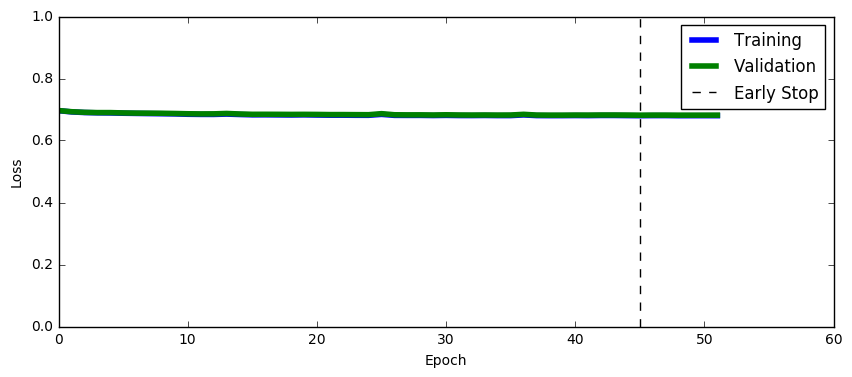

In [17]:
print_loss(model)

In [18]:
def plot_sequence_filters(dnn):
    fig = plt.figure(figsize=(15, 8))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    conv_filters = dnn.get_sequence_filters()
    num_plots_per_axis = int(len(conv_filters)**0.5) + 1
    for i, conv_filter in enumerate(conv_filters):
        ax = fig.add_subplot(num_plots_per_axis, num_plots_per_axis, i+1)
        add_letters_to_axis(ax, conv_filter.T)
        ax.axis("off")
        ax.set_title("Filter %s" % (str(i+1)))

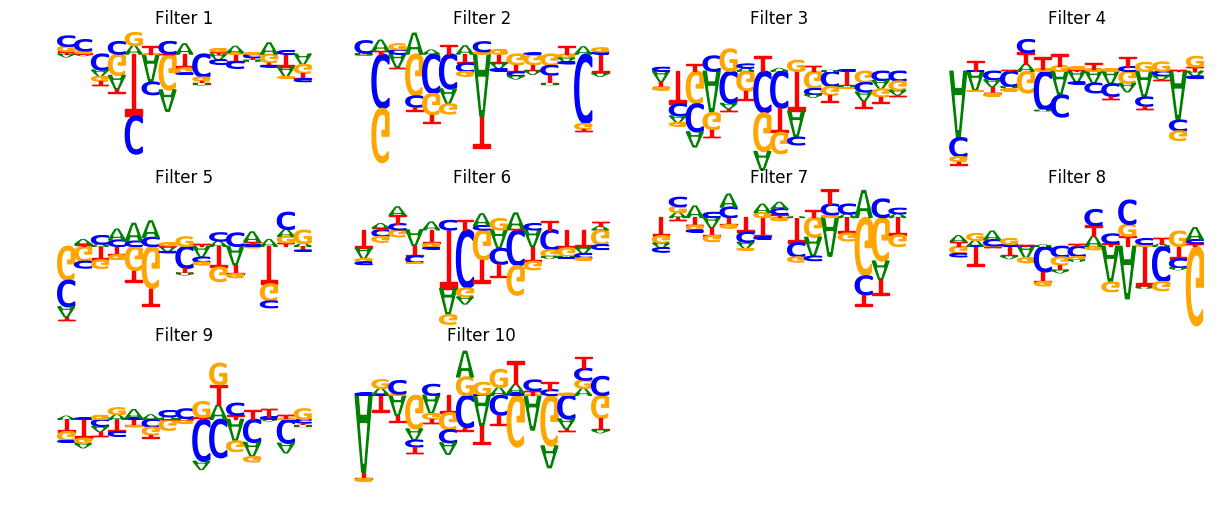

In [19]:
plot_sequence_filters(model)

Try a larger model.

In [ ]:
multi_filter_model = models.SequenceDNN(
    seq_length=X_train.shape[3],
    num_filters=[15, 15, 15],
    conv_width=[15, 15, 15],
    num_tasks=y_train.shape[1],
    dropout=0.1
)

In [ ]:
multi_filter_model.train(X_train, y_train, (X_valid, y_valid))

In [ ]:
print_loss(multi_filter_model)